In [1]:
!pip install --quiet /kaggle/input/kerasapplications
!pip install --quiet /kaggle/input/efficientnet-keras-source-code

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, os, random, re
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
import efficientnet.tfkeras as efn
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
strategy.num_replicas_in_sync

8

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-tfrecords-512x512')
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 30
SEED = 42
FOLDS = 5

In [5]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform_mat(image, DIM=IMAGE_SIZE[0]):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32')
    
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d, [DIM, DIM,3])

def dropout(image, DIM=IMAGE_SIZE[0], PROBABILITY = 0.5, CT = 4, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [6]:
def onehot(image,label):
    return image,tf.one_hot(label,len(CLASSES))


def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
        
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

def transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = 5
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image1 = []
    for j in range(AUG_BATCH):
        img = transform_mat(image[j,])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        image1.append(img)
        
    image1 = tf.reshape(tf.stack(image1),(AUG_BATCH,DIM,DIM,3))
    image2, label2 = cutmix(image1, label, CUTMIX_PROB)
    image3, label3 = mixup(image1, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

In [7]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0     ###
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
rng = tf.random.Generator.from_seed(SEED, alg='philox')

def data_augment(image, label):
    seed = rng.make_seeds(2)[0]
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image = tf.image.stateless_random_flip_up_down(image, seed=seed)
    image = tf.image.stateless_random_brightness(image, 0.3, seed=seed)
    image = dropout(image)
    return image, label

def get_training_dataset(FILENAMES):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(AUG_BATCH)
    dataset = dataset.map(transform, num_parallel_calls=AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048, seed = SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(FILENAMES):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(onehot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [9]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/Id_train*.tfrec")

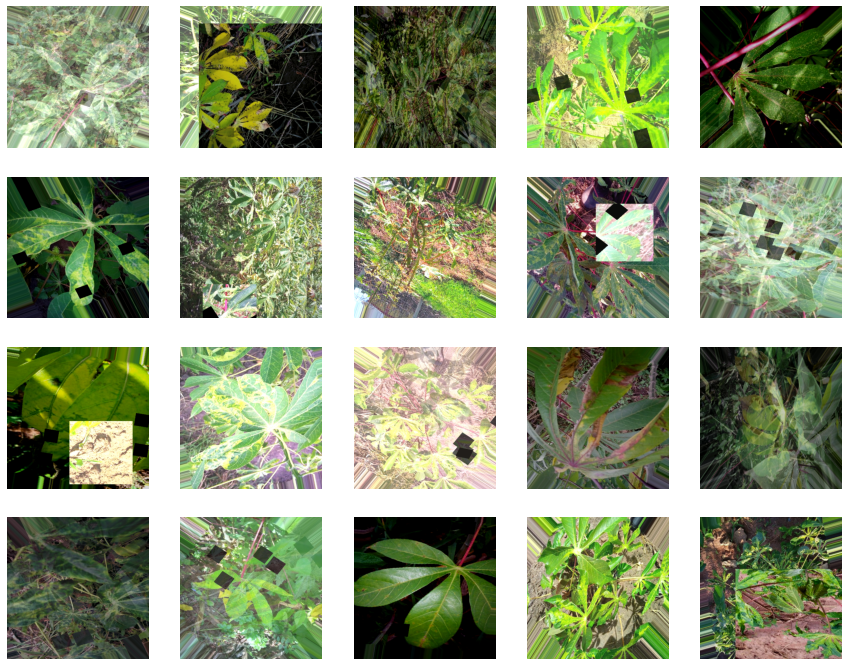

In [10]:
row = 5; col = 5;
row = min(row,20//col)
all_elements = get_training_dataset([TRAINING_FILENAMES[0]]).unbatch()
augmented_element = all_elements.batch(20)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [11]:
def get_lr_callback(batch_size=BATCH_SIZE):
    lr_start   = 0.000001
    lr_max     = 0.00000125 * strategy.num_replicas_in_sync * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 5
    lr_decay   = 0.88
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [12]:
def get_model():
    with strategy.scope():       
        input_layer = tf.keras.layers.Input(shape=(512,512,3))
        base = efn.EfficientNetB4(input_shape=(512,512,3),weights='noisy-student',include_top=False)
        base.trainable = True
        
        x = base(input_layer)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output_layer = tf.keras.layers.Dense(5,activation='softmax')(x)
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
        
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=False,
            label_smoothing=0.0001,  #0.001
            name='categorical_crossentropy')
        
        model.compile(optimizer=opt,loss=loss,metrics=['categorical_accuracy'])
    return model

model = get_model()
print(model.summary())
del model

71680000/71678424 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, 16, 16, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________
None


In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [14]:
CP = tf.keras.callbacks.ModelCheckpoint('fcomp_model.h5',
                                            monitor='categorical_accuracy', verbose=1, save_best_only=True,
                                            save_weights_only=False, mode='max', save_freq='epoch')

In [15]:
model = get_model()
history = model.fit(get_training_dataset(TRAINING_FILENAMES), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    #validation_data=valid_dataset,
                    #validation_steps=VALID_STEPS,
                    callbacks = [get_lr_callback(BATCH_SIZE), CP])

Epoch 1/30
167/167 [==============================] - 249s 643ms/step - loss: 1.6269 - categorical_accuracy: 0.2403

Epoch 00001: categorical_accuracy improved from -inf to 0.27624, saving model to fcomp_model.h5
Epoch 2/30
167/167 [==============================] - 105s 629ms/step - loss: 1.0037 - categorical_accuracy: 0.6663

Epoch 00002: categorical_accuracy improved from 0.27624 to 0.72086, saving model to fcomp_model.h5
Epoch 3/30
167/167 [==============================] - 102s 614ms/step - loss: 0.7002 - categorical_accuracy: 0.7819

Epoch 00003: categorical_accuracy improved from 0.72086 to 0.78462, saving model to fcomp_model.h5
Epoch 4/30
167/167 [==============================] - 105s 629ms/step - loss: 0.6806 - categorical_accuracy: 0.7923

Epoch 00004: categorical_accuracy improved from 0.78462 to 0.79164, saving model to fcomp_model.h5
Epoch 5/30
167/167 [==============================] - 104s 625ms/step - loss: 0.6583 - categorical_accuracy: 0.8001

Epoch 00005: categoric

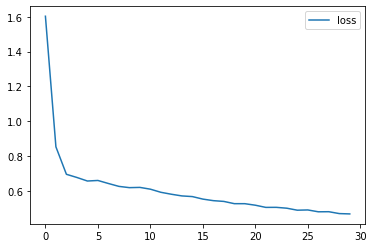

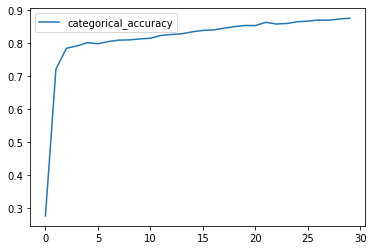

In [17]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()                      #, 'val_loss'
history_frame.loc[:, ['categorical_accuracy']].plot();         #,  'val_sparse_categorical_accuracy'

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/Id_train*.tfrec")
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

In [ ]:
for f, (trn_ind, val_ind) in enumerate(skf.split(TRAINING_FILENAMES)):
    print("FOLD-{}".format(f+1))
    print()
    
    TRAIN_FILENAMES = list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES'])
    VALID_FILENAMES = list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES'])
    
    train_dataset = get_training_dataset(TRAIN_FILENAMES)
    valid_dataset = get_validation_dataset(VALID_FILENAMES)
    
    NUM_TRAINING_IMAGES = count_data_items(TRAIN_FILENAMES)
    NUM_VALID_IMAGES = count_data_items(VALID_FILENAMES)
    
    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
    VALID_STEPS = NUM_VALID_IMAGES // BATCH_SIZE
    
    CP = tf.keras.callbacks.ModelCheckpoint('f_model%02d_best.h5'%(f+1),
                                            monitor='val_categorical_accuracy', verbose=1, save_best_only=True,
                                            save_weights_only=False, mode='max', save_freq='epoch')
    
    model = get_model()
    history = model.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS,
                        validation_data=valid_dataset,
                        validation_steps=VALID_STEPS,
                        callbacks = [get_lr_callback(BATCH_SIZE), CP])
    
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['sparse_categorical_accuracy',  'val_sparse_categorical_accuracy']].plot();
    
    del model